In [1]:
from google.colab import files
data_to_load = files.upload()

Saving day_approach_maskedID_timeseries.csv to day_approach_maskedID_timeseries.csv


In [2]:

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [3]:
raw_df = pd.read_csv('day_approach_maskedID_timeseries.csv')
convert_dict = {'nr. sessions': int } #convert nr.sessions to int 
raw_df = raw_df.astype(convert_dict)
raw_df.head()

,nr. sessions,total km,km Z3-4,km Z5-T1-T2,km sprinting,strength training,hours alternative,perceived exertion,perceived trainingSuccess,perceived recovery,...,km Z5-T1-T2.6,km sprinting.6,strength training.6,hours alternative.6,perceived exertion.6,perceived trainingSuccess.6,perceived recovery.6,Athlete ID,injury,Date
0,1,5.8,0.0,0.6,1.2,0.0,0.00,0.11,0.00,0.18,...,0.0,0.0,0.0,1.0,0.10,0.00,0.15,0,0,0
1,0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,...,0.5,1.2,0.0,0.0,0.10,0.00,0.17,0,0,1
2,1,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,...,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,0,0,2
3,0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,...,0.0,0.0,1.0,0.0,0.10,0.00,0.17,0,0,3
4,1,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,...,0.0,0.0,0.0,0.0,0.11,0.00,0.17,0,0,4


In [4]:
# This section displays the percentage of the majority class
neg, pos = np.bincount(raw_df['injury'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 42766
    Positive: 583 (1.36% of total)



In [5]:
#Dropping the unnecessary columns/features
cleaned_df = raw_df.copy()
cleaned_df.pop('Date')
cleaned_df.pop('Athlete ID')

0         0
1         0
2         0
3         0
4         0
         ..
42761    71
42762    71
42763    71
42764    71
42765    71
Name: Athlete ID, Length: 42766, dtype: int64

In [6]:
X = cleaned_df.drop('injury', axis = 1)
y = cleaned_df['injury']

Applying Synthetic Minority Oversampling Technique (SMOTE)

In [8]:
from imblearn.over_sampling import SMOTE
#This is because the data is so imbalanced. The minority class is oversampled with new similar data is generated to compensate its minimal numbers
smote_technique = SMOTE(sampling_strategy='minority')
X_smt, y_smt = smote_technique.fit_resample(X, y)

In [9]:
y_smt.value_counts() #class counts now match

0    42183
1    42183
Name: injury, dtype: int64

In [10]:

#Data is split to Train and test 
X_train_smt, X_test_smt, y_train_smt, y_test_smt = train_test_split(X_smt, y_smt, test_size=0.3, random_state=15, stratify=y_smt)

In [11]:
# check shape of training and test data
print("Training data size: ", X_train_smt.shape)
print("Test data size: ", X_test_smt.shape)

Training data size:  (59056, 70)
Test data size:  (25310, 70)


##RANDOM FOREST CLASSIFIER

In [12]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_smt, y_train_smt)

RandomForestClassifier()

In [13]:
#Using the trained model, the prediction is done on the test set
rfc_preds_smt = rfc.predict(X_test_smt)
rfc_preds_smt = np.round(rfc_preds_smt)

In [14]:
from sklearn.metrics import confusion_matrix , classification_report
#Display the classification report of the model out of prediction using the test data
print(classification_report(y_test_smt, rfc_preds_smt))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12655
           1       1.00      0.98      0.99     12655

    accuracy                           0.99     25310
   macro avg       0.99      0.99      0.99     25310
weighted avg       0.99      0.99      0.99     25310



In [15]:
#function to display the confusion matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Correct Non-injury predictions (True Negatives): ', cm[0][0])
    print('Incorrect Non-injury predictions (False Positives): ', cm[0][1])
    print('Correct injury predictions (False Negatives): ', cm[1][0])
    print('Incorrect injury predictions (True Positives): ', cm[1][1])
    print('Total injury predictions: ', np.sum(cm[1]))

Correct Non-injury predictions (True Negatives):  12648
Incorrect Non-injury predictions (False Positives):  7
Correct injury predictions (False Negatives):  208
Incorrect injury predictions (True Positives):  12447
Total injury predictions:  12655


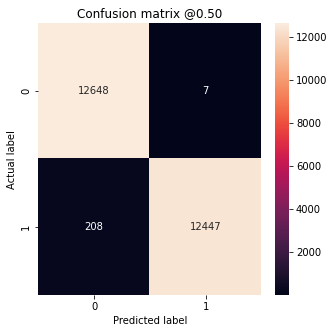

In [16]:
plot_cm(y_test_smt, rfc_preds_smt)